In [26]:
import pandas as pd
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df = pd.read_csv("Zomato Dataset.csv")
df = df.drop("Delivery_person_ID", axis=1)
df["Order_Date"] = pd.to_datetime(df["Order_Date"], format="%d-%m-%Y")
df["Road_traffic_density"] = df["Road_traffic_density"].replace("High", "Jam")
df.head()

# in "Time_Orderd" and Time_Order_picked column, there are multiple invalid times which we will drop 
# 1. force columns to string
df["Time_Orderd"] = df["Time_Orderd"].astype(str)
df["Time_Order_picked"] = df["Time_Order_picked"].astype(str)

# 2. remove invalid 24:xx times
df = df[~df["Time_Orderd"].str.startswith("24:")]
df = df[~df["Time_Order_picked"].str.startswith("24:")]

# 3. keep only rows containing a colon (:)
df = df[df["Time_Orderd"].str.contains(":", na=False)]
df = df[df["Time_Order_picked"].str.contains(":", na=False)]

# 4. trim seconds (HH:MM:SS → HH:MM)
df["Time_Orderd"] = df["Time_Orderd"].str.slice(0, 5)
df["Time_Order_picked"] = df["Time_Order_picked"].str.slice(0, 5)

# 5. convert to datetime
df["Time_Orderd"] = pd.to_datetime(df["Time_Orderd"], format="%H:%M")
df["Time_Order_picked"] = pd.to_datetime(df["Time_Order_picked"], format="%H:%M")

def haversine_miles(lat1, lon1, lat2, lon2):
    R = 3958.8  # Earth radius in miles

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)*2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)*2
    d = 2 * R * np.arcsin(np.sqrt(a))
    return d

df["distance_miles"] = haversine_miles(
    df["Restaurant_latitude"],
    df["Restaurant_longitude"],
    df["Delivery_location_latitude"],
    df["Delivery_location_longitude"]
)

df = df.dropna()

/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
# def one_encoding_df(df, column):
#     dummies = pd.get_dummies(df[column], drop_first=False)
#     dummies["ID"] = df["ID"]
#     dummies = dummies[["ID"] + [c for c in dummies.columns if c != "ID"]]
#     return dummies

# weather_df   = one_encoding_df(df, "Weather_conditions")
# traffic_df   = one_encoding_df(df, "Road_traffic_density")
# order_df     = one_encoding_df(df, "Type_of_order")
# vehicle_df   = one_encoding_df(df, "Type_of_vehicle")
# festival_df  = one_encoding_df(df, "Festival")
# city_df      = one_encoding_df(df, "City")

categorical_cols = ["Weather_conditions",
                    "Road_traffic_density",
                    "Type_of_order",
                    "Type_of_vehicle",
                    "Festival",
                    "City"]

df_clean = pd.get_dummies(df, columns=categorical_cols, drop_first=False)
df_clean["Hour"] = df["Time_Orderd"].dt.hour
hourly_counts = df_clean.groupby("Hour").size()

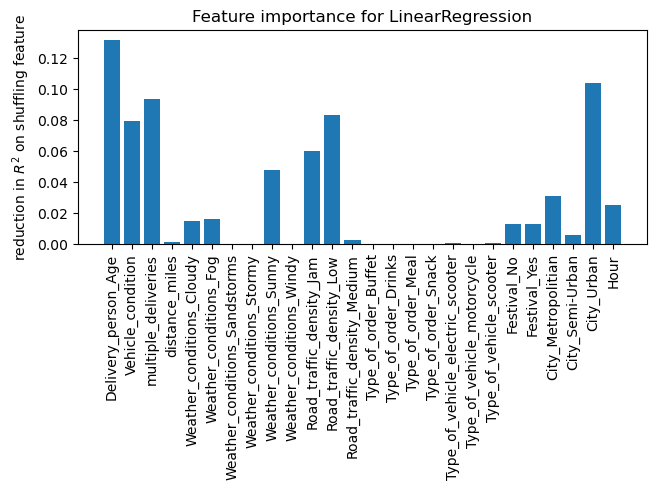

In [4]:
# features = ['Delivery_person_Age', 'Delivery_person_Ratings',
#        'Restaurant_latitude', 'Restaurant_longitude',
#        'Delivery_location_latitude', 'Delivery_location_longitude',
#        'Weather_conditions',
#        'Road_traffic_density', 'Vehicle_condition', 'Type_of_order',
#        'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City',
#        'Time_taken (min)']

y = df_clean["Time_taken (min)"]
X = df_clean.drop(columns=["Time_taken (min)", "ID", "Time_Orderd", 
                           "Time_Order_picked", "Order_Date", 'Restaurant_latitude', 
                           'Restaurant_longitude', 'Delivery_location_latitude', 
                           'Delivery_location_longitude', "Delivery_person_Ratings"])

model = linear_model.LinearRegression()
model.fit(X, y)
pi = permutation_importance(estimator=model, X=X, y=y, random_state=0)
plt.bar(x=range(X.columns.size), height=pi.importances_mean, tick_label=X.columns)
plt.xticks(rotation='vertical') 
plt.tight_layout()
plt.title('Feature importance for LinearRegression')
_ = plt.ylabel(r'reduction in $R^2$ on shuffling feature')

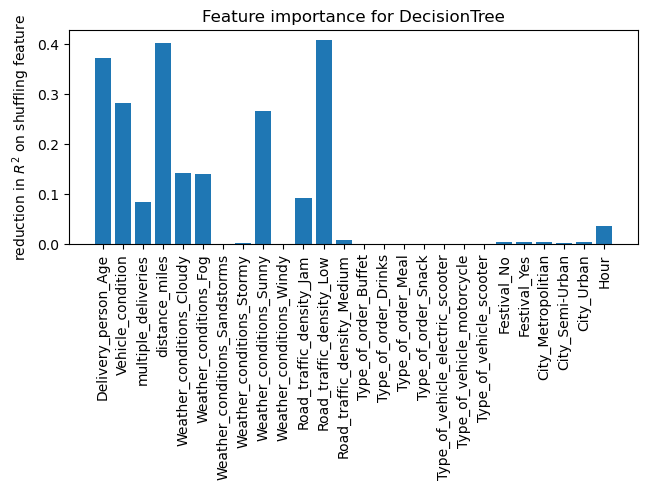

In [5]:
model = DecisionTreeRegressor(max_depth=10)
model.fit(X, y)
pi = permutation_importance(estimator=model, X=X, y=y, random_state=0)
plt.bar(x=range(X.columns.size), height=pi.importances_mean, tick_label=X.columns)
plt.xticks(rotation='vertical') 
plt.tight_layout()
plt.title('Feature importance for DecisionTree')
_ = plt.ylabel(r'reduction in $R^2$ on shuffling feature')

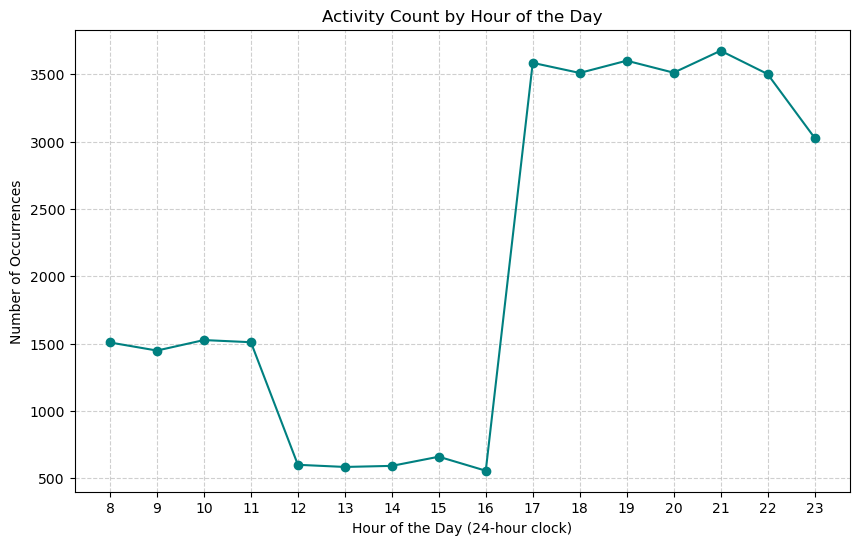

In [6]:
plt.figure(figsize=(10, 6))

# The index (hours) becomes the x-axis, and values (counts) become the y-axis
hourly_counts.plot(kind='line', marker='o', color='teal')

plt.title('Activity Count by Hour of the Day')
plt.xlabel('Hour of the Day (24-hour clock)')
plt.ylabel('Number of Occurrences')
plt.xticks(range(8, 24)) # Ensure all hours (0-23) are shown as ticks
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()

Predictions

In [7]:
all_features = ['Delivery_person_Age', 'Vehicle_condition', 'multiple_deliveries', 
               'Weather_conditions', 'Road_traffic_density', 'City', "distance_miles"]
numeric_features = ['Delivery_person_Age', 'Vehicle_condition', 'multiple_deliveries', "distance_miles"]
categorical_features = ['Weather_conditions', 'Road_traffic_density', 'City']

X = df[all_features]
y = df['Time_taken (min)']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state = 0, stratify = y, test_size=0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, random_state = 0, test_size=0.5)


preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=50))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Delivery_person_Age',
                                                   'Vehicle_condition',
                                                   'multiple_deliveries',
                                                   'distance_miles']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Weather_conditions',
                                                   'Road_traffic_density',
                                                   'City'])])),
                ('model',
                 DecisionTreeRegressor(max_depth=10, min_samples_leaf=5,
                                       min_samples_split=50))])

In [8]:
print(f"{clf.score(X_valid, y_valid):.3}")

0.781


In [9]:
all_features = ['Delivery_person_Age', 'Vehicle_condition', 'multiple_deliveries', 
               'Weather_conditions', 'Road_traffic_density', 'City', "distance_miles"]
numeric_features = ['Delivery_person_Age', 'Vehicle_condition', 'multiple_deliveries', "distance_miles"]
categorical_features = ['Weather_conditions', 'Road_traffic_density', 'City']

X = df[all_features]
y = df['Time_taken (min)']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state = 0, test_size=0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, random_state = 0, test_size=0.5)


preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestRegressor(max_depth=10, n_estimators=100))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Delivery_person_Age',
                                                   'Vehicle_condition',
                                                   'multiple_deliveries',
                                                   'distance_miles']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Weather_conditions',
                                                   'Road_traffic_density',
                                                   'City'])])),
                ('model', RandomForestRegressor(max_depth=10))])

In [10]:
print(f"{clf.score(X_valid, y_valid):.3}")
clf.named_steps['model'].feature_importances_

0.785


array([0.13354392, 0.10058974, 0.15435424, 0.12443105, 0.05703501,
       0.02228154, 0.02743674, 0.14479468, 0.02350413, 0.16521762,
       0.04037327, 0.00147114, 0.00496693])

In [11]:
from sklearn.model_selection import GridSearchCV

# 1. Define the parameter grid for the RandomForest inside the pipeline
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30]
}

# 2. Wrap your pipeline in GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,              # your pipeline
    param_grid=param_grid,
    cv=5,                       # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # or 'neg_root_mean_squared_error'
    n_jobs=-1,                  # use all cores
    verbose=2
)

# 3. Fit on the training data
grid_search.fit(X_train, y_train)

# 4. Best hyperparameters and best model
print("Best params:", grid_search.best_params_)
print("Best CV score (MAE):", -grid_search.best_score_)

best_model = grid_search.best_estimator_

# 5. Evaluate on validation and test sets
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_valid_pred = best_model.score(X_valid, y_valid)


print(f"{y_valid_pred}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....model__max_depth=None, model__n_estimators=100; total time=   3.8s
[CV] END .....model__max_depth=None, model__n_estimators=300; total time=  11.3s


Exception ignored in: <function ResourceTracker.__del__ at 0x1031bdbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .....model__max_depth=None, model__n_estimators=100; total time=   3.8s
[CV] END .....model__max_depth=None, model__n_estimators=300; total time=  11.4s


Exception ignored in: <function ResourceTracker.__del__ at 0x1028ddbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END .....model__max_depth=None, model__n_estimators=100; total time=   3.8s
[CV] END .....model__max_depth=None, model__n_estimators=300; total time=  11.4s


Exception ignored in: <function ResourceTracker.__del__ at 0x107ee9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END .....model__max_depth=None, model__n_estimators=100; total time=   3.9s
[CV] END .....model__max_depth=None, model__n_estimators=300; total time=  11.4s


Exception ignored in: <function ResourceTracker.__del__ at 0x103565bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END .....model__max_depth=None, model__n_estimators=100; total time=   3.9s
[CV] END .....model__max_depth=None, model__n_estimators=300; total time=  11.5s


Exception ignored in: <function ResourceTracker.__del__ at 0x103ee9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Best params: {'model__max_depth': 10, 'model__n_estimators': 100}
Best CV score (MAE): 3.4800193850223877
0.7845857722790835


In [30]:
from sklearn.model_selection import GridSearchCV

# 1. Define the parameter grid for the RandomForest inside the pipeline
knn = KNeighborsRegressor(metric='euclidean')
param_grid = {"n_neighbors":[1,2,3,4]}

# 2. Wrap your pipeline in GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,              # your pipeline
    param_grid=param_grid,
    cv=5,                       # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # or 'neg_root_mean_squared_error'
    n_jobs=-1,                  # use all cores
    verbose=2
)

# 3. Fit on the training data
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_



y_valid_pred = best_model.score(X_valid, y_valid)


print(f"{y_valid_pred}")
print("Best CV score (MAE):", -grid_search.best_score_)
print("Best params:", grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


ValueError: 
All the 20 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/neighbors/_regression.py", line 222, in fit
    return self._fit(X, y)
           ~~~~~~~~~^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/neighbors/_base.py", line 478, in _fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self,
        ^^^^^
    ...<5 lines>...
        ensure_all_finite=ensure_all_finite,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        X,
    ...<12 lines>...
        input_name="X",
    )
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/opt/anaconda3/lib/python3.13/site-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Windy'


In [14]:
grid_search.best_params_

{'model__max_depth': 10, 'model__n_estimators': 100}

In [28]:
all_features = ['Delivery_person_Age', 'Vehicle_condition', 'multiple_deliveries', 
               'Weather_conditions', 'Road_traffic_density', 'City', "distance_miles"]
numeric_features = ['Delivery_person_Age', 'Vehicle_condition', 'multiple_deliveries', "distance_miles"]
categorical_features = ['Weather_conditions', 'Road_traffic_density', 'City']

X = df[all_features]
y = df['Time_taken (min)']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state = 0, stratify = y, test_size=0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, random_state = 0, test_size=0.5)


preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', GradientBoostingRegressor(max_depth = 10, n_estimators = 100))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Delivery_person_Age',
                                                   'multiple_deliveries',
                                                   'distance_miles']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Weather_conditions',
                                                   'Road_traffic_density',
                                                   'City'])])),
                ('model', GradientBoostingRegressor(max_depth=10))])

In [29]:
print(f"{clf.score(X_valid, y_valid)}")

0.6553800071095948


In [23]:
all_features = ['Delivery_person_Age', 'Vehicle_condition', 'multiple_deliveries', 
               'Weather_conditions', 'Road_traffic_density', 'City', "distance_miles"]
numeric_features = ['Delivery_person_Age', 'Vehicle_condition', 'multiple_deliveries', "distance_miles"]
categorical_features = ['Weather_conditions', 'Road_traffic_density', 'City']

estimators = [
    ('GradientBooosting', GradientBoostingRegressor(max_depth = 10, n_estimators = 100)),
    ('DecisionTree', DecisionTreeRegressor(max_depth=10, random_state=0))
]

X = df[all_features]
y = df['Time_taken (min)']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state = 0, stratify = y, test_size=0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, random_state = 0, test_size=0.5)


preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', StackingRegressor(
    estimators=estimators, final_estimator=RandomForestRegressor(max_depth=10, n_estimators=100)))])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Delivery_person_Age',
                                                   'Vehicle_condition',
                                                   'multiple_deliveries',
                                                   'distance_miles']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Weather_conditions',
                                                   'Road_traffic_density',
                                                   'City'])])),
                ('model',
                 StackingRegressor(estimators=[('GradientBooosting',
                                                GradientBoostingRegressor(max_depth=10)),
                                               ('DecisionTree',
                                                DecisionTreeRegressor(max_depth=10,
                                                                      random_state=0))],
                                   final_estimator=RandomForestRegressor(max_depth=10)))])

In [24]:
clf.score(X_valid, y_valid)

0.8056565943557847